In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from scipy import stats
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from scipy.stats import kurtosis, skew

In [2]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
import pandas as pd

def extract_features(sensor_data):
    feature_names = ['Mean', 'Std', 'Skewness', 'Kurtosis', 'Min', 'Max', 'RMS', 'Var', 'Power', 'Peak',
                     'P2P', 'Crest Factor', 'Form Factor', 'Pulse Indicator', 'Max Freq', 'Sum Freq',
                     'Mean Freq', 'Var Freq', 'Peak Freq', 'Skewness Freq', 'Kurtosis Freq',
                     'Peak Index', 'Zero Crossing Rate', 'Entropy']

    all_features = []

    for signal in sensor_data:
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        skewness = skew(signal)
        kurt = kurtosis(signal)
        min_val = np.min(signal)
        max_val = np.max(signal)
        rms = np.sqrt(np.mean(signal**2))
        var = np.var(signal)
        power = np.mean(signal**2)
        peak = np.max(np.abs(signal))
        p2p = np.ptp(signal)
        crest_factor = np.max(np.abs(signal)) / np.sqrt(np.mean(signal**2))
        form_factor = rms / mean_val
        pulse_indicator = peak / mean_val

        # Frequency Domain Features
        ft = fft(signal)
        S = np.abs(ft**2) / len(signal)
        max_f = np.max(S)
        sum_f = np.sum(S)
        mean_f = np.mean(S)
        var_f = np.var(S)
        peak_f = np.max(np.abs(S))
        skew_f = skew(S)
        kurtosis_f = kurtosis(S)
        
        # Additional Time Domain Features
        peak_index = np.argmax(signal)
        zero_crossing_rate = ((np.roll(signal, 1) * signal) <= 0).sum()
        entropy = stats.entropy(np.abs(signal))

        # Append all features to the list
        all_features.append([mean_val, std_val, skewness, kurt, min_val, max_val, rms, var, power, peak,
                            p2p, crest_factor, form_factor, pulse_indicator, 
                             max_f, sum_f, mean_f, var_f, peak_f, skew_f, kurtosis_f,
                             peak_index, zero_crossing_rate, entropy])

    # Create a DataFrame with feature names as columns
    df_features = pd.DataFrame(all_features, columns=feature_names)
    
    return df_features


In [3]:
# Load and process data

data_folder = "ML_data"  # Change this to your data folder path

normal_signals = []
fault_signals = []

# Load normal signals
for file_name in os.listdir(os.path.join(data_folder, "Normal")):
    if file_name.endswith(".csv"):
        signal = pd.read_csv(os.path.join(data_folder, "Normal", file_name)).values
        normal_signals.append(signal)

# Load fault signals
for file_name in os.listdir(os.path.join(data_folder, "Faulty")):
    if file_name.endswith(".csv"):
        signal = pd.read_csv(os.path.join(data_folder, "Faulty", file_name)).values
        fault_signals.append(signal)

# Convert lists to arrays
normal_signals = np.array(normal_signals)
fault_signals = np.array(fault_signals)
     

In [4]:
database_path = "ML_data"

# Specify the subfolders for normal and faulty data
normal_folder = "Normal"
faulty_folder = "Faulty"

# Function to read data from a CSV file
def read_data_from_csv(file_path):
    return pd.read_csv(file_path, header=None).squeeze("columns").values

# Function to concatenate raw vectors from a folder
def concatenate_raw_vectors(folder_path):
    files = os.listdir(folder_path)
    raw_vectors = []
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        raw_vector = read_data_from_csv(file_path)
        raw_vectors.append(raw_vector)
    return np.array(raw_vectors)

# Construct the full path to the normal and faulty folders
normal_folder_path = os.path.join(database_path, normal_folder)
faulty_folder_path = os.path.join(database_path, faulty_folder)

# Concatenate raw vectors for normal and faulty data
normal_data = concatenate_raw_vectors(normal_folder_path)
faulty_data = concatenate_raw_vectors(faulty_folder_path)

print("Shape of Normal Data Array:", normal_data.shape)
print("Shape of Faulty Data Array:", faulty_data.shape)
first_channel_normal = normal_data[:, :, 0]  # Shape: (10, 51200)
first_channel_faulty = faulty_data[:, :, 0]  # Shape: (10, 51200)

Shape of Normal Data Array: (10, 51200, 2)
Shape of Faulty Data Array: (10, 51200, 2)


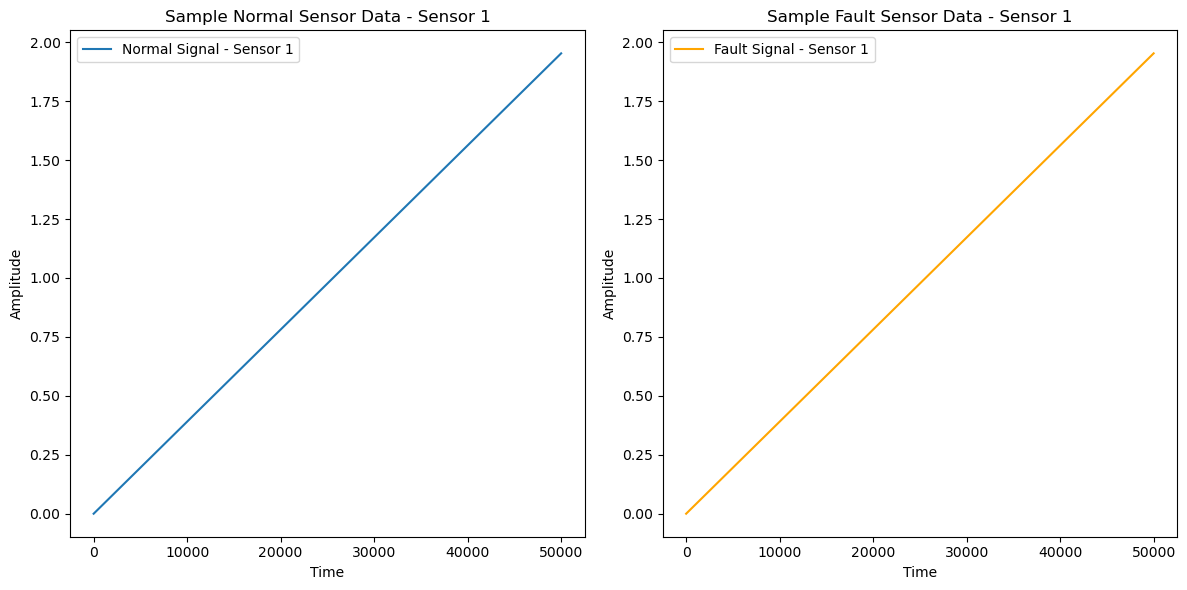

In [5]:
#Plot sample sensor data
plt.figure(figsize=(12, 6))

# Plot normal sensor data
plt.subplot(1, 2, 1)
plt.plot(first_channel_normal[0, :50000], label='Normal Signal - Sensor 1')
plt.title("Sample Normal Sensor Data - Sensor 1")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

# Plot fault sensor data
plt.subplot(1, 2, 2)
plt.plot(first_channel_faulty[0, :50000], label='Fault Signal - Sensor 1', color='orange')
plt.title("Sample Fault Sensor Data - Sensor 1")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
normal_features_list = []
faulty_features_list = []
# Extract features for normal and faulty data
normal_features_df = extract_features(first_channel_normal)
faulty_features_df = extract_features(first_channel_faulty)

print("Shape of Normal Features Array:", normal_features_df.shape)
print("Shape of Faulty Features Array:", faulty_features_df.shape)

Shape of Normal Features Array: (10, 24)
Shape of Faulty Features Array: (10, 24)


In [7]:
print(normal_features_df.head(5))

      Mean      Std      Skewness  Kurtosis  Min       Max       RMS  \
0  0.99998  0.57735  1.651659e-10      -1.2  0.0  1.999961  1.154684   
1  0.99998  0.57735  1.651659e-10      -1.2  0.0  1.999961  1.154684   
2  0.99998  0.57735  1.651659e-10      -1.2  0.0  1.999961  1.154684   
3  0.99998  0.57735  1.651659e-10      -1.2  0.0  1.999961  1.154684   
4  0.99998  0.57735  1.651659e-10      -1.2  0.0  1.999961  1.154684   

        Var     Power      Peak  ...      Max Freq      Sum Freq  Mean Freq  \
0  0.333333  1.333294  1.999961  ...  51198.000006  68264.666658   1.333294   
1  0.333333  1.333294  1.999961  ...  51198.000006  68264.666658   1.333294   
2  0.333333  1.333294  1.999961  ...  51198.000006  68264.666658   1.333294   
3  0.333333  1.333294  1.999961  ...  51198.000006  68264.666658   1.333294   
4  0.333333  1.333294  1.999961  ...  51198.000006  68264.666658   1.333294   

       Var Freq     Peak Freq  Skewness Freq  Kurtosis Freq  Peak Index  \
0  52332.000196  

In [8]:
normal_features = normal_features_df.to_numpy()
faulty_features = faulty_features_df.to_numpy()

X = pd.concat([normal_features_df, faulty_features_df], axis=0)

# Create labels (0 for normal, 1 for faulty)
y = pd.Series([0] * normal_features_df.shape[0] + [1] * faulty_features_df.shape[0], name='Label')


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Initialize SVM model
svm_model = SVC(kernel='linear', C=1.0, gamma='scale')

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy in %: {accuracy*100:.2f}",
      f"Recall score in %: {recall*100:.2f}",
      f"Precision score in %: {precision*100:.2f}"
      )


Accuracy in %: 50.00 Recall score in %: 100.00 Precision score in %: 50.00


In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
 
#make prediction 
y_pred = rfc.predict(X_test)
 
#evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
 
#print the result
print(f"Accuracy in %: {accuracy*100:.2f}",
       f"Recall score in %: {recall*100:.2f}",
       f"Precision score in %: {precision*100:.2f}"
      ) 

Accuracy in %: 50.00 Recall score in %: 100.00 Precision score in %: 50.00


### Feature Selection using SVC

In [15]:
from sklearn.svm import SVC

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Initialize the SVM model
svm_model = SVC(kernel='linear')  # You can use 'rbf' or other kernels based on your needs

# Fit the SVM model
svm_model.fit(X_train, y_train)

# Get feature importances or coefficients (for linear SVM)
if svm_model.kernel == 'linear':
    feature_importance = pd.Series(abs(svm_model.coef_[0]), index=X.columns)
    sorted_feature_importance = feature_importance.sort_values(ascending=False)
    print(sorted_feature_importance)
else:
    print("Feature importances are not directly available for non-linear SVMs like 'rbf'.")
    print("You may consider using other feature selection techniques for non-linear SVMs.")


Sum Freq              8.731149e-11
Var Freq              5.820766e-11
Max Freq              4.365575e-11
Kurtosis Freq         4.365575e-11
Peak Freq             4.365575e-11
Skewness Freq         1.705303e-13
Entropy               3.552714e-15
Mean Freq             1.332268e-15
Form Factor           1.332268e-15
Peak                  8.881784e-16
P2P                   8.881784e-16
Crest Factor          8.881784e-16
Max                   8.881784e-16
Power                 4.440892e-16
Skewness              1.550964e-25
Std                   0.000000e+00
Pulse Indicator       0.000000e+00
Var                   0.000000e+00
RMS                   0.000000e+00
Min                   0.000000e+00
Kurtosis              0.000000e+00
Peak Index            0.000000e+00
Zero Crossing Rate    0.000000e+00
Mean                  0.000000e+00
dtype: float64


In [16]:
top_features = feature_importance.sort_values(ascending=False).head(5).index
print(top_features)
# Select only the top 5 features from your original feature matrix
X_train_new = X_train[top_features]
X_test_new = X_test[top_features]

print(X_train_new.shape)
#-----------------------------------------------------------
# Train a classifier using only the top 5 features
rfc_top_5 = RandomForestClassifier()
rfc_top_5.fit(X_train_new, y_train)

# Make predictions on the test set
y_pred = rfc_top_5.predict(X_test_new)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using top 5 features- Random Forest: {accuracy*100:.2f}")


# Initialize SVM model
svm_model = SVC(kernel='linear', C=1.0, gamma='scale')

# Train the SVM model
svm_model.fit(X_train_new, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_new)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using top features- SVM: {accuracy*100:.2f}")


Index(['Sum Freq', 'Var Freq', 'Max Freq', 'Kurtosis Freq', 'Peak Freq'], dtype='object')
(16, 5)
Accuracy using top 5 features- Random Forest: 74.66
Accuracy using top features- SVM: 78.00


In [17]:
from sklearn.feature_selection import RFE

# Assuming svm_model is your trained SVM model
selector = RFE(svm_model, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)

# Get selected features
selected_features = selector.support_
print("Selected Features:", selected_features)



Selected Features: [False False False False False False False False False False False False
 False False  True  True False  True  True False  True False False False]


In [18]:
top_features = feature_importance.sort_values(ascending=False).head(5).index
print(top_features)
# Select only the top 5 features from your original feature matrix
X_train_new = X_train[top_features]
X_test_new = X_test[top_features]

print(X_train_new.shape)
#-----------------------------------------------------------
# Train a classifier using only the top 5 features
rfc_top_5 = RandomForestClassifier()
rfc_top_5.fit(X_train_new, y_train)

# Make predictions on the test set
y_pred = rfc_top_5.predict(X_test_new)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using top 5 features- Random Forest: {accuracy*100:.2f}")


# Initialize SVM model
svm_model = SVC(kernel='linear', C=1.0, gamma='scale')

# Train the SVM model
svm_model.fit(X_train_new, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_new)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using top features- SVM: {accuracy*100:.2f}")


Index(['Sum Freq', 'Var Freq', 'Max Freq', 'Kurtosis Freq', 'Peak Freq'], dtype='object')
(16, 5)
Accuracy using top 5 features- Random Forest: 50.00
Accuracy using top features- SVM: 50.00


### Dimension Reduction

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA  # Import PCA

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Encode categorical variables (if applicable)
label_encoder = LabelEncoder()
# Apply label encoding to categorical columns
# Example: X_train_encoded = label_encoder.fit_transform(X_train_categorical)

# Scale the data before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Apply PCA on scaled data
pca = PCA()
pca.fit(X_train_scaled)


In [23]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.seterr(divide='ignore', invalid='ignore')
# Assuming X is your feature matrix and y is your label vector

# Apply PCA to reduce the number of features
n_components = 1  # Specify the number of components (adjust as needed)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
# Split the data into training and testing sets


In [24]:
# Create a RandomForestClassifier (replace this with your actual model)
rfc = RandomForestClassifier()
rfc.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = rfc.predict(X_test_pca)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy -RFC PCA: {accuracy*100:.2f}")



# Initialize SVM model
svm_model = SVC(kernel='linear', C=1.0, gamma='scale')

# Train the SVM model
svm_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_pca)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy - SVM PCA: {accuracy*100:.2f}")
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)



Accuracy -RFC PCA: 78.2
Accuracy - SVM PCA: 82.77
